# News Topic Classifier Using BERT

🎯 Goal:Build a BERT-based model to classify news headlines into categories like World, Sports, Business, and Sci/Tech.

✅ Objective:
Fine-tune bert-base-uncased on the AG News dataset, evaluate with accuracy and F1-score, and deploy using Gradio or Streamlit.


You can access the dataset used for this project here: [Telco Customer Churn IBM Dataset](https://www.kaggle.com/datasets/yeanzc/telco-customer-churn-ibm-dataset?resource=download)

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Telco_customer_churn.xlsx to Telco_customer_churn (2).xlsx


# Telco Churn Prediction – Boosting Recall for Class 1 (Churn) with Logistic Regression and Random Forest

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# Load dataset

In [5]:
df = pd.read_excel('Telco_customer_churn.xlsx')

# Drop unnecessary columns

In [6]:
drop_cols = ['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code', 'Lat Long',
             'Churn Label', 'Churn Reason', 'Churn Score']
df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)

# Convert Total Charges to numeric

In [7]:
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')
df['Total Charges'].fillna(df['Total Charges'].median(), inplace=True)

/tmp/ipython-input-7-3587890574.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Total Charges'].fillna(df['Total Charges'].median(), inplace=True)


# Target and features

In [8]:
y = df['Churn Value']
X = df.drop(['Churn Value'], axis=1)

# Split dataset

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Column types

In [11]:
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# Preprocessors

In [12]:
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

# Logistic Regression pipeline (with class_weight)

In [13]:
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', solver='liblinear'))
])

# Random Forest pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Hyperparameters

In [16]:
logreg_params = {'classifier__C': [0.1, 1, 10]}
rf_params = {'classifier__n_estimators': [100, 200], 'classifier__max_depth': [None, 10, 20]}

# GridSearchCV
grid_logreg = GridSearchCV(logreg_pipeline, logreg_params, cv=5, scoring='recall')
grid_rf = GridSearchCV(rf_pipeline, rf_params, cv=5, scoring='recall')

# Fit both models

In [17]:
grid_logreg.fit(X_train, y_train)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Latitude',
                                                                          'Longitude',
                                                                          'Tenure '
                                                                          'Months',
                                                                          'Monthly '
                                                                          'Charges',
                                                                          'Total '
                                                                          'Charges',
                                                                          'CLTV']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent'))...
                                                                          'Service',
                                                                          'Online '
                                                                          'Security',
                                                                          'Online '
                                                                          'Backup',
                                                                          'Device '
                                                                          'Protection',
                                                                          'Tech '
                                                                          'Support',
                                                                          'Streaming '
                                                                          'TV',
                                                                          'Streaming '
                                                                          'Movies',
                                                                          'Contract',
                                                                          'Paperless '
                                                                          'Billing',
                                                                          'Payment '
                                                                          'Method'])])),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__n_estimators': [100, 200]},
             scoring='recall')

# Evaluate both

In [18]:
print("📌 Logistic Regression Results:")
logreg_pred = grid_logreg.predict(X_test)
print("Best Params:", grid_logreg.best_params_)
print("Confusion Matrix:\n", confusion_matrix(y_test, logreg_pred))
print("Classification Report:\n", classification_report(y_test, logreg_pred))

print("\n📌 Random Forest Results:")
rf_pred = grid_rf.predict(X_test)
print("Best Params:", grid_rf.best_params_)
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_pred))
print("Classification Report:\n", classification_report(y_test, rf_pred))

📌 Logistic Regression Results:
Best Params: {'classifier__C': 10}
Confusion Matrix:
 [[758 277]
 [ 80 294]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.73      0.81      1035
           1       0.51      0.79      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.75      0.76      1409


📌 Random Forest Results:
Best Params: {'classifier__max_depth': 10, 'classifier__n_estimators': 200}
Confusion Matrix:
 [[831 204]
 [105 269]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.80      0.84      1035
           1       0.57      0.72      0.64       374

    accuracy                           0.78      1409
   macro avg       0.73      0.76      0.74      1409
weighted avg       0.80      0.78      0.79      1409



# Pick better model based on recall

In [19]:
from sklearn.metrics import recall_score
recall_logreg = recall_score(y_test, logreg_pred)
recall_rf = recall_score(y_test, rf_pred)

if recall_rf > recall_logreg:
    print(f"\n✅ Random Forest selected (Recall: {recall_rf:.2f})")
    best_model = grid_rf.best_estimator_
else:
    print(f"\n✅ Logistic Regression selected (Recall: {recall_logreg:.2f})")
    best_model = grid_logreg.best_estimator_

# Save final model
joblib.dump(best_model, 'telco_churn_final_model.pkl')

# Predict on a sample
sample = X_test.iloc[[0]]
print("\nSample Prediction:", best_model.predict(sample))

import matplotlib.pyplot as plt

# STEP 1: Only do feature importance if best model is Logistic Regression
if isinstance(best_model.named_steps['classifier'], LogisticRegression):
    print("\n🔍 Feature Importance for Logistic Regression:")

    # Get preprocessing and classifier objects
    preprocessor = best_model.named_steps['preprocessor']
    classifier = best_model.named_steps['classifier']

    # Get transformed feature names
    num_features = preprocessor.transformers_[0][2]
    cat_features = preprocessor.transformers_[1][1]['encoder'].get_feature_names_out(preprocessor.transformers_[1][2])
    all_features = np.concatenate([num_features, cat_features])

    # Get coefficients
    coef = classifier.coef_[0]

    # Combine features and coefficients
    feature_importance = pd.DataFrame({
        'Feature': all_features,
        'Coefficient': coef
    })

    # Sort by absolute impact
    feature_importance['AbsCoefficient'] = np.abs(feature_importance['Coefficient'])
    feature_importance = feature_importance.sort_values(by='AbsCoefficient', ascending=False).head(15)


✅ Logistic Regression selected (Recall: 0.79)

Sample Prediction: [0]

🔍 Feature Importance for Logistic Regression:


# Plot


🔍 Feature Importance for Logistic Regression:


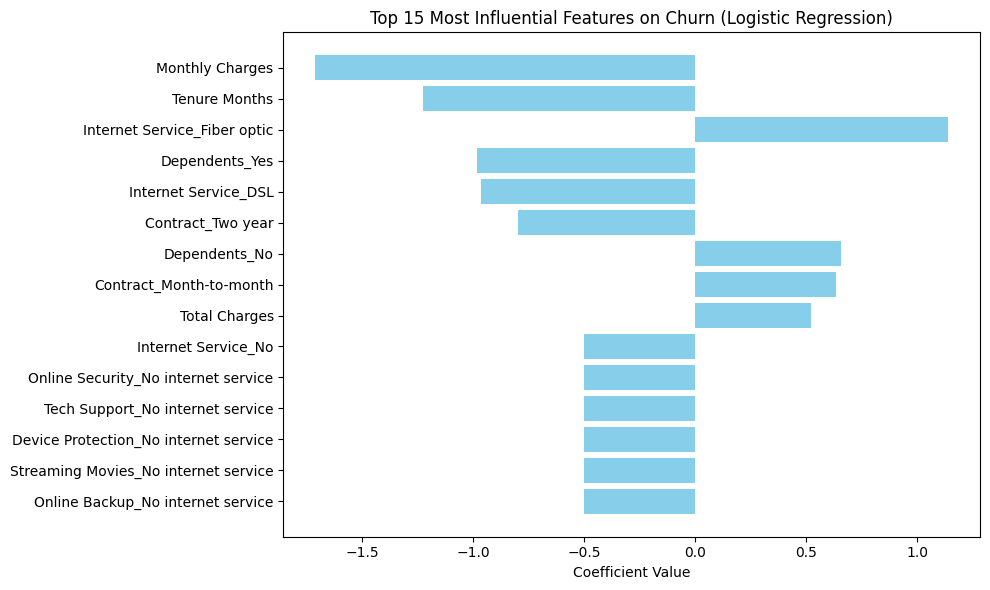

In [21]:
import matplotlib.pyplot as plt

# STEP 1: Only do feature importance if best model is Logistic Regression
if isinstance(best_model.named_steps['classifier'], LogisticRegression):
    print("\n🔍 Feature Importance for Logistic Regression:")

    # Get preprocessing and classifier objects
    preprocessor = best_model.named_steps['preprocessor']
    classifier = best_model.named_steps['classifier']

    # Get transformed feature names
    num_features = preprocessor.transformers_[0][2]
    cat_features = preprocessor.transformers_[1][1]['encoder'].get_feature_names_out(preprocessor.transformers_[1][2])
    all_features = np.concatenate([num_features, cat_features])

    # Get coefficients
    coef = classifier.coef_[0]

    # Combine features and coefficients
    feature_importance = pd.DataFrame({
        'Feature': all_features,
        'Coefficient': coef
    })

    # Sort by absolute impact
    feature_importance['AbsCoefficient'] = np.abs(feature_importance['Coefficient'])
    feature_importance = feature_importance.sort_values(by='AbsCoefficient', ascending=False).head(15)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color='skyblue')
    plt.xlabel('Coefficient Value')
    plt.title('Top 15 Most Influential Features on Churn (Logistic Regression)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

else:
    print("Feature importance plot is only available for Logistic Regression in this version.")